In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import k3d
import time
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

from utilis.resize_label import *
from utilis.callbacks import *
from utilis.utilis import *
from models.unet import *
from models.encoders.vgg_encoder import *

# Get data and labels

In [2]:
# !ls /data/cornucopia/ib255/derivative_datasets/cued_scene_coordinate_regression/data_from_jason/DS_003_JDB-Full/coordinates/

In [3]:
coord_data_dir = "/data/cornucopia/ib255/derivative_datasets/cued_scene_coordinate_regression/data_from_jason/DS_003_JDB-Full/coordinates/"

In [43]:
data_size = 1
images = np.zeros((data_size, 2048, 4096, 3))
labels = np.zeros((data_size, 2048, 4096, 3))


for data in range(1,data_size + 1):
    coord_npz = f"{data:03}_rendered.png_config.npz"
    npz_data = np.load(coord_data_dir + coord_npz)
    
    images[int(data)-1,:,:,:] = npz_data['image_colors'].astype(int)
    labels[int(data)-1,:,:,:] = npz_data['points_3d_camera'] 

# Downsample and crop

In [12]:
def downsample(batch_size, images, labels, new_res=(256, 512)):
    """ We choose to downsample to 256x512 and then crop 224x224 images. Downsampling to
    256x512 has proven to work well in practice, although we ourselves haven't tested that statement."""
    
    images_low = np.zeros((batch_size, new_res[0], new_res[1], 3))
    labels_low = np.zeros((batch_size, new_res[0], new_res[1], 3))

    for ind in range(batch_size):
        images_low[ind,:,:,:] = cv2.resize(images[ind,:,:,:], new_res[::-1], interpolation = cv2.INTER_CUBIC)
        labels_low[ind,:,:,:] = cv2.resize(labels[ind,:,:,:], new_res[::-1], interpolation = cv2.INTER_NEAREST)
        
    return images_low, labels_low



def get_image_crops(num_crops, image, label):
    """ Images are equirectangular (360 projected onto a rectangle).
    Therefore we have to allow for all possibe crops, including these that run across the right image edge. """
    
    image_crops = np.zeros((num_crops, 224, 224, 3))
    label_crops = np.zeros((num_crops, 224, 224, 3))
  
    # pick the start cordinates of croped images
    image_res = image.shape[:2]
    start_row = np.random.randint(0, high=image_res[0]-224, size=num_crops)
    start_col = np.random.randint(0, high=image_res[1], size=num_crops)
    
    # get all pixels that span 224 to the right and down from start pixels
    # if a croped image runs across right image border, then use concatenate to combine pixels of croped image
    for ind in range(num_crops):

        if start_col[ind]+224 > 512:
            dif = start_col[ind]+224 - 512
            wraped_image = image[start_row[ind]:start_row[ind]+224, :dif,:]
            wraped_label = label[start_row[ind]:start_row[ind]+224, :dif,:]
            image_crops[ind] = np.concatenate((image[start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:], wraped_image), axis=1)
            label_crops[ind] = np.concatenate((label[start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:], wraped_label), axis=1)
        
        else:
            image_crops[ind] = image[start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:]
            label_crops[ind] = label[start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:]
           
    
    return image_crops, label_crops

In [13]:
images_low, labels_low = downsample(data_size, images, labels)

In [14]:
images_low.shape

(1, 256, 512, 3)

In [15]:
croped_img, croped_lbl = get_image_crops(4, images_low[0], labels_low[0])

In [8]:
croped_img.shape

(4, 224, 224, 3)

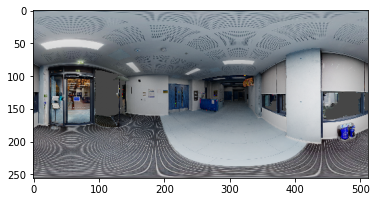

In [8]:
for img in images_low:
    plt.imshow(img.astype('uint8'))
    plt.show()

In [9]:
plot = k3d.plot(name='points')
plt_points = k3d.points(positions=croped_lbl[3], point_size=0.2)
plot += plt_points
plt_points.shader='3d'
plot.display()

/home/mlmi-2020/jz522/localisation_from_image_project/envs/loc/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

# Data Generator

In [4]:
def get_file_name(ind):
    if ind < 10:
        ind = "00" + str(ind)
    elif ind < 100:
        ind = "0" + str(ind)

    coord_npz = "0{}_rendered.png_config.npz".format(str(ind))
    return coord_npz

In [5]:
def get_data(val_split=0.2):
    """ NOTE: we will need to improve this so that we can easily define: 
    (1) partition rule, (2) which directory the data is loaded from """
    
    data_partition = {'train': [],
                     'validation': []}

    data_size=370
    indexes = np.arange(1,371)
    np.random.shuffle(indexes)
    split_index = int(val_split*data_size)

    for ind in indexes[split_index:]:
        coord_npz = get_file_name(ind)
        npz_data = np.load(coord_data_dir + coord_npz)

        data_partition['train'].append(coord_npz)

    for ind in indexes[:split_index]:
        coord_npz = get_file_name(ind)
        npz_data = np.load(coord_data_dir + coord_npz)

        data_partition['validation'].append(coord_npz)
    
    return data_partition

In [6]:
data_partition = get_data()

In [33]:
# import numpy as np
# import keras

class DataGenerator(keras.utils.Sequence):
    """ Loads, downsamples, crops, and auguments images and labels """
    
    def __init__(self, npz_file_IDs, room_dir=None, batch_size=8, dim=(256,512), n_channels=3, shuffle=True, num_crops=4):

        self.npz_file_IDs = npz_file_IDs
        self.room_dir = room_dir
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.num_crops = num_crops

    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.npz_file_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
            
    def load_data(self, npz_file_ID_temp):
        """ Load .npz files with images and labels from self.room_dir """
        images = np.empty((self.batch_size, 2048, 4096, self.n_channels))
        labels = np.empty((self.batch_size, 2048, 4096, self.n_channels))

        for i, ID in enumerate(npz_file_ID_temp):
            npz_data = np.load(self.room_dir + ID)
            
            start_time = time.time()
            images[i] = npz_data['image_colors'].astype(int)
            print("--- %s images ---" % (time.time() - start_time))
            
            start_time = time.time()
            labels[i] = npz_data['points_3d_camera']
            print("--- %s labels ---" % (time.time() - start_time))
            
            images[i] = npz_data['image_colors'].astype(int)
            labels[i] = npz_data['points_3d_camera']

        return images, labels
    
    
    def downsample(self, images, labels):
        """ We choose to downsample to 256x512 and then crop 224x224 images. Downsampling to
        256x512 has proven to work well in practice, although we ourselves haven't tested that statement."""
        images_low_res = np.zeros((self.batch_size, *self.dim, self.n_channels))
        labels_low_res = np.zeros((self.batch_size, *self.dim, self.n_channels))

        for ind in range(self.batch_size):
            images_low_res[ind,:,:,:] = cv2.resize(images[ind,:,:,:], self.dim[::-1], interpolation = cv2.INTER_CUBIC)
            labels_low_res[ind,:,:,:] = cv2.resize(labels[ind,:,:,:], self.dim[::-1], interpolation = cv2.INTER_NEAREST)

        return images_low_res, labels_low_res

    
    def get_image_crops(self, images, labels):
        """ Images are equirectangular (360 projected onto a rectangle).
        Therefore we have to allow for all possibe crops, including these that run across the right image edge. """

        image_crops = np.zeros((self.batch_size*self.num_crops, 224, 224, self.n_channels))
        label_crops = np.zeros((self.batch_size*self.num_crops, 224, 224, self.n_channels))

        for ind_1 in range(self.batch_size):
            
            # pick the start cordinates of croped images
            start_row = np.random.randint(0, high=self.dim[0]-224, size=self.num_crops)
            start_col = np.random.randint(0, high=self.dim[1], size=self.num_crops)

            # get all pixels that span 224 to the right and down from start pixels
            # if a croped image runs across right image border, then use concatenate to combine pixels of croped image
            for ind_2 in range(self.num_crops):

                if start_col[ind_2] + 224 > 512:
                    dif = start_col[ind_2] + 224 - 512
                    wraped_image = images[ind_1, start_row[ind_2]:start_row[ind_2]+224, :dif,:]
                    wraped_label = labels[ind_1, start_row[ind_2]:start_row[ind_2]+224, :dif,:]
                    
                    image_crops[ind_1*self.num_crops + ind_2] = np.concatenate(
                        (images[ind_1, start_row[ind_2]:start_row[ind_2]+224, start_col[ind_2]:start_col[ind_2]+224,:], 
                         wraped_image), axis=1)
                    label_crops[ind_1*self.num_crops + ind_2] = np.concatenate(
                        (labels[ind_1, start_row[ind_2]:start_row[ind_2]+224, start_col[ind_2]:start_col[ind_2]+224,:], 
                         wraped_label), axis=1)

                else:
                    image_crops[ind_1*self.num_crops + ind_2] = images[ind_1, start_row[ind_2]:start_row[ind_2]+224, start_col[ind_2]:start_col[ind_2]+224,:]
                    label_crops[ind_1*self.num_crops + ind_2] = labels[ind_1, start_row[ind_2]:start_row[ind_2]+224, start_col[ind_2]:start_col[ind_2]+224,:]


        return image_crops, label_crops
    
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.npz_file_IDs) / self.batch_size))
    
    
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.npz_file_IDs[k] for k in indexes]

#         start_time = time.time()
        # Get images & labels
        images, labels = self.load_data(list_IDs_temp)
#         print("--- %s loading ---" % (time.time() - start_time))

        # Downsample
        images, labels = self.downsample(images, labels)

        # crop
        images, labels = self.get_image_crops(images, labels)
    
        return images, labels

In [34]:
coord_data_dir = "/data/cornucopia/ib255/derivative_datasets/cued_scene_coordinate_regression/data_from_jason/DS_003_JDB-Full/coordinates/"

# Parameters
generator_params = {"room_dir": coord_data_dir,
          "batch_size": 1,
          "dim": (256,512),
          "n_channels": 3,
          "shuffle": True,
          "num_crops": 4}

training_generator = DataGenerator(data_partition['train'], **generator_params)
validation_generator = DataGenerator(data_partition['validation'], **generator_params)

In [38]:
images, labels = training_generator.__getitem__(1)

--- 1.7550134658813477 images ---
--- 2.9457104206085205 labels ---


In [25]:
images.shape

(4, 224, 224, 3)

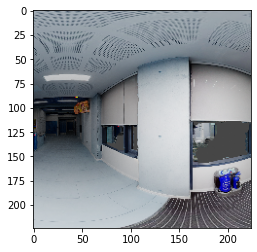

Output()

In [17]:
for img, label in zip(images[:1], labels[:1]):
    plt.imshow(img.astype('uint8'))
    plt.show()
    
    plot = k3d.plot(name='points')
    plt_points = k3d.points(positions=croped_lbl[3], point_size=0.2)
    plot += plt_points
    plt_points.shader='3d'
    plot.display()

# Write a simple model

In [58]:
def vgg_unet(input_height=224, input_width=224):

    model = unet(vgg_encoder, input_height=input_height, input_width=input_width)
    model.model_name = "vgg_unet"
    
    return model

In [15]:
strategy = tf.distribute.MirroredStrategy(['/device:GPU:2', '/device:GPU:3', '/device:GPU:4', '/device:GPU:5'])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    
    compile_configs = {'metrics': [keras.metrics.MeanAbsoluteError()]}
                   
    fit_configs = {'callbacks': [RemoveGarbaseCallback(),
    #                            Visualise_learning(images_low[0], labels_low[0]
                                                  ],
#                    'batch_size': 128,
                   'epochs': 5,
                   'verbose': 1}
    
    generator_configs = {"room_dir": coord_data_dir,
          "batch_size": 8,
          "dim": (256,512),
          "n_channels": 3,
          "shuffle": True,
          "num_crops": 4}

    training_generator = DataGenerator(data_partition['train'], **params)
    validation_generator = DataGenerator(data_partition['validation'], **params)
    
    unet_model = vgg_unet()
    unet_model.compile(loss='mse', optimizer=keras.optimizers.Adam(0.0001), **compile_configs)

InternalError: CUDA runtime implicit initialization on GPU:2 failed. Status: out of memory

In [60]:
# visualise_training = Visualise_learning(croped_img[0], croped_img[0], 20)

In [61]:
start_t = time.time()
unet_model.fit(x=training_generator, epochs=10, verbose=1)#, callbacks=[visualise_training])
print("--- %s seconds ---" % (time.time() - start_t))

--- 5.273075580596924 seconds ---
Epoch 1/10
--- 5.252633571624756 seconds ---


ResourceExhaustedError:  OOM when allocating tensor with shape[32,128,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node functional_11/block2_conv2/Relu (defined at <ipython-input-61-eaca5b7ffbd5>:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_18538]

Function call stack:
train_function


In [10]:
images_low.shape

(1, 224, 224, 3)

In [ ]:
# croped_img, croped_lbl

In [31]:
import time
start_time = time.time()
unet_model.fit(x=images, y=labels, epochs=10, verbose=1) #, callbacks=[visualise_training])
print("--- %s seconds ---" % (time.time() - start_time))


Epoch 1/10
1/1 [==============================] - 0s 44ms/step - loss: 0.9915 - mean_absolute_error: 0.7207
Epoch 2/10
1/1 [==============================] - 0s 43ms/step - loss: 0.8785 - mean_absolute_error: 0.6878
Epoch 3/10
1/1 [==============================] - 0s 42ms/step - loss: 0.7978 - mean_absolute_error: 0.6654
Epoch 4/10
1/1 [==============================] - 0s 38ms/step - loss: 0.7545 - mean_absolute_error: 0.6519
Epoch 5/10
1/1 [==============================] - 0s 41ms/step - loss: 0.7215 - mean_absolute_error: 0.6386
Epoch 6/10
1/1 [==============================] - 0s 39ms/step - loss: 0.6837 - mean_absolute_error: 0.6219
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.6481 - mean_absolute_error: 0.6057
Epoch 8/10
1/1 [==============================] - 0s 38ms/step - loss: 0.6195 - mean_absolute_error: 0.5941
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.5934 - mean_absolute_error: 0.5823
Epoch 10/10
1/1 [===========

In [62]:
pred_y = unet_model.predict(images_low)

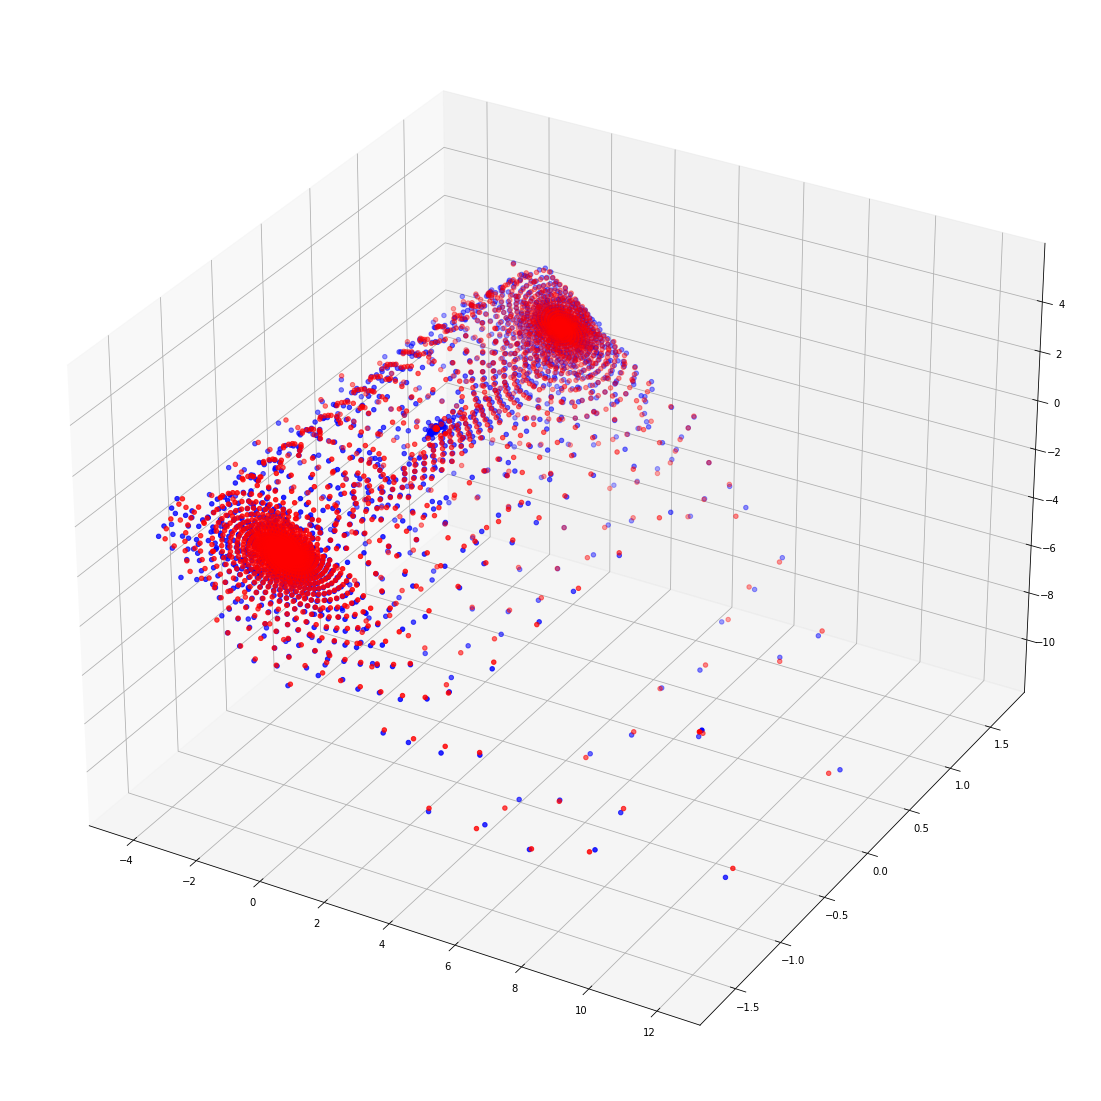

In [103]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

xyz = labels_low[0,:,:,:].reshape(-1, labels_low[0,:,:,:].shape[-1])[::20]
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c='r', marker='o')

xyz = pred_y[0,:,:,:].reshape(-1, pred_y[0,:,:,:].shape[-1])[::20]
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c='b', marker='o')

In [92]:
plot = k3d.plot(name='points')
plt_points = k3d.points(positions=labels_low[2], point_size=0.2, color=0xff0000, alpha=0.5)
plot += plt_points
plt_points = k3d.points(positions=pred_y[2], point_size=0.2, color=0x0000ff, alpha=0.5)
plot += plt_points
plt_points.shader='3d'
plot.display()

Output()

In [93]:
plot.fetch_screenshot()

In [94]:
with open('screenshot.png', 'wb') as f:
#     try:
#         out = plot.screenshot.decode('base64')
#     except: # Python 3
    from base64 import b64decode
    out = b64decode(plot.screenshot)    
    f.write(out)
    
Image(url='screenshot.png')

In [82]:
plot.screenshot

''

In [75]:
image_dir = plot.screenshot
img = mpimg.imread(image_dir)
plt.imshow(img)

AttributeError: 'str' object has no attribute 'read'

TypeError: Image data of dtype <U1 cannot be converted to float

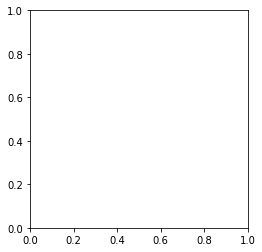

In [69]:
plt.imshow(plot.screenshot)